In [12]:
#!pip install requests==2.32.4 --quiet



In [13]:
#pip install langchain langchain_core langchain_groq langchain_community langgraph

In [14]:
import os
from typing import TypedDict,Annotated,List
from langgraph.graph import StateGraph,END
from langchain_core.messages import HumanMessage,AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display,Image

In [15]:
class PlannerState(TypedDict):
  messages:Annotated[List[HumanMessage|AIMessage],'the message in the conversation']
  city:str
  interest:List[str]
  itinerary:str


In [16]:
import os 
from dotenv import load_dotenv
load_dotenv()
groq_api_key=os.getenv("GROQ_API_KEY")
from langchain_groq import ChatGroq
llm=ChatGroq(
    temperature=0,
    groq_api_key=groq_api_key,
    model_name='llama-3.3-70b-versatile'
)
result=llm.invoke("what is human")

python-dotenv could not parse statement starting at line 11
python-dotenv could not parse statement starting at line 12
python-dotenv could not parse statement starting at line 13


In [17]:
result.content

'The question "what is human" is a complex and multifaceted one that has been debated and explored by philosophers, scientists, anthropologists, and many others across various disciplines. The answer can vary depending on the context and perspective, but here\'s a comprehensive overview:\n\n**Biological Perspective:**\nFrom a biological standpoint, humans (Homo sapiens) are a species of primates that belong to the family Hominidae. We are characterized by our upright posture, binocular vision, and a highly developed brain. Humans are composed of approximately 37.2 trillion cells, with a unique genetic makeup that sets us apart from other species.\n\n**Physical Characteristics:**\nHumans have a range of physical characteristics, including:\n\n1. Upright posture: We walk on two legs, which allows us to move efficiently and use our hands for other tasks.\n2. Brain development: Our brain is highly developed, with a large cerebral cortex, which enables advanced cognitive functions, such as 

In [18]:
itinerary_promopt=ChatPromptTemplate.from_messages([
    ('system','You are a helpgul travel assistant.Create a day trip itinerary for {city} based on users interest :{interest} .Provide a brief bullet itinerary'),
    ('human','Create an itinerary for my dat trip')
])

In [19]:
def input_city(state:PlannerState)->PlannerState:
  print("Please eneter the city you want to visit for your day trip:")
  user_message=input('Your input:')
  return {
      **state,
      'city':user_message,
      'messages':state['messages']+[HumanMessage(content=user_message)]
  }
def input_interest(state:PlannerState)->PlannerState:
  print(f"Please eneter your interest for the trip to :{state['city']}(comma-separated):")
  user_message=input('Your input:')
  return {
      **state,
      'interest':[interest.strip() for interest in user_message.split(',')],
      'messages':state['messages']+[HumanMessage(content=user_message)]
  }
def create_itinerary(state:PlannerState)->PlannerState:
  print(f"Creating an itinerary for {state['city']} based on interest: {','.join(state['interest'])}"),

  response=llm.invoke(itinerary_promopt.format_messages(city=state['city'],interest=','.join(state['interest'])))
  print("Final itinerary")
  print(response.content)
  return {
      **state,

      'messages':state['messages']+[AIMessage(content=response.content)],
      'itinerary':response.content
  }

In [20]:
workflow=StateGraph(PlannerState)

workflow.add_node('input_city',input_city)
workflow.add_node('input_interest',input_interest)
workflow.add_node('create_itinerary',create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge('input_city','input_interest')
workflow.add_edge('input_interest','create_itinerary')
workflow.add_edge('create_itinerary',END)

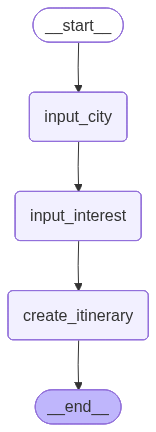

In [21]:
app=workflow.compile()
app

In [22]:
def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content=user_request)],
      "city": "",
      "interest": [],
      "itinerary": "",
  }
  for output in app.stream(state):
    pass

In [23]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please eneter the city you want to visit for your day trip:
Please eneter your interest for the trip to :nainital(comma-separated):
Creating an itinerary for nainital based on interest: lake
Final itinerary
Based on your interest in lakes, I've created a day trip itinerary for Nainital. Here's a brief bullet itinerary:

* 8:00 AM: Start the day with a visit to **Naini Lake**, a beautiful lake with boating facilities
* 10:00 AM: Take a stroll around the **Mall Road**, which offers stunning views of the lake
* 12:00 PM: Visit **Bhimtal Lake**, a larger and quieter lake with a beautiful island garden
* 2:00 PM: Have lunch at a lakeside restaurant with a view of **Bhimtal Lake**
* 4:00 PM: Explore **Naukuchiatal Lake**, a lake with nine corners and a peaceful atmosphere
* 6:00 PM: Return to Nainital and enjoy a **sunrise or sunset view** of Naini Lake

This itinerary provides a mix of lake visits, scenic views, and relaxation, and can be adjusted

In [24]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [26]:
import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

# Define the LLM
llm = ChatGroq(
    temperature=0,
    groq_api_key=groq_api_key,
    model_name="llama-3.3-70b-versatile"
)

# Define the itinerary prompt
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

def input_city(city: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "city": city,
        "messages": state['messages'] + [HumanMessage(content=city)],
    }

def input_interests(interests: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "interests": [interest.strip() for interest in interests.split(',')],
        "messages": state['messages'] + [HumanMessage(content=interests)],
    }

def create_itinerary(state: PlannerState) -> str:
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    state["itinerary"] = response.content
    state["messages"] += [AIMessage(content=response.content)]
    return response.content

# Define the Gradio application
def travel_planner(city: str, interests: str):
    # Initialize state
    state = {
        "messages": [],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    # Process the city and interests inputs
    state = input_city(city, state)
    state = input_interests(interests, state)

    # Generate the itinerary
    itinerary = create_itinerary(state)

    return itinerary

# Build the Gradio interface
interface = gr.Interface(
    fn=travel_planner,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="Enter your interests (comma-separated)"),
    ],
    outputs=gr.Textbox(label="Generated Itinerary"),
    title="Travel Itinerary Planner",
    description="Enter a city and your interests to generate a personalized day trip itinerary."
)

# Launch the Gradio application
interface.launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
